정리 노트 #5

소프트웨어 202284011 김연재

4차원 데이터 예제

In [53]:
import numpy as np

x = np.random.rand(10, 1, 28, 28) #높이 28 너비 28 채널 1 데이터 10
x.shape

(10, 1, 28, 28)

In [54]:
x[0].shape

(1, 28, 28)

In [55]:
# x[0, 0]

# array([[0.57815553, 0.68313083, 0.62716526, 0.50664272, 0.97832108,
#         0.66660523, 0.98195606, 0.19604657, 0.85770642, 0.99375825,
#         0.39941726, 0.40717357, 0.60560674, 0.58461899, 0.51636388,
#         0.7799932 , 0.221066  , 0.44128729, 0.54017635, 0.87901173,
#         0.8342617 , 0.2021888 , 0.70324414, 0.30168567, 0.25876091,
#         0.73762666, 0.85439377, 0.75170196],
#         ...

# 결과가 너무 많아서 일부분만 주석으로 기록

합성곱 연산 구현의 문제점 - for문을 겹겹이 써야함
넘파이에 for문을 사용하면 성능이 떨어진다는 단점도 있음

im2col 함수를 사용한 구현
입력 데이터를 필터링하기 좋게 전해하는 함수
3차원 입력 데이터에 im2col을 적용하면 2차원 행렬도 바뀜
메모리를 더 많이 소비하는 단점이 있음
문제를 행렬 계산으로 만들면 선형 대수 라이브러리를 활용해 효율을 높일 수 있음

im2col 함수의 인터페이스
im2col(input_data, filter_h, filter_w, stride=1, pad=0)

In [56]:
import sys, os
import numpy as np
sys.path.append(os.pardir)
from common.util import im2col

In [57]:
x1 = np.random.rand(1, 3, 7, 7) # 데이터 수, 채널 수, 높이, 너비
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)

(9, 75)


In [58]:
x2 = np.random.rand(10, 3, 7, 7) # 데이터 수, 채널 수, 높이, 너비
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(90, 75)


합성곱 계층은 필터(가중치), 편향, 스트라이드, 패딩을 인수로 받아 초기화한다.
필터는 (FN, C, FH, FW)의 4차원 형상이다. FN = 필터의 개수, C = 채널, FH = 필터의 높이, FW = 필터의 너비

In [59]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad) # 1. 입력데이터를 im2col로 전개
        col_W =self.W.reshape(FN, -1).T # 2. 필터도 reshape을 사용해 2차원 배열로 전개
                                        # reshape에 -1을 지정하면 다차원 배열의 원소 수가 변환 후에도 똑같이 유지 되도록 적절히 묶어줌
        out = np.dot(col, col_W) + self.b # 3. 전개한 두 행렬의 곱을 구함

        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2) # 4. 출력 데이터를 적절한 형상으로 바꿔줌
                                                                    # transpose 함수를 사용하여 다차원 배열의 축 순서를 바꿈
        return out

폴링 계층의 구현 세 단계
1. 입력 데이터를 전개한다.
2. 행별 최댓값을 구한다.
3. 적절한 모양으로 성형한다.

In [60]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool.h) / self.stride)
        out_w = int(1 + (W - self.pool.w) / self.stride)

        # (1) 전개
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)

        # (2) 최댓값
        out = np.max(col, axis=1)

        # (3) 성형
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        return out

CNN 계층 구현하기
다음과 같은 CNN을 구현한다.
Convolution(입력 데이터의 특징을 추출) -> ReLU -> Pooling(적절한 모양으로 성형) -> Affine(행렬곱 연산) -> ReLU -> Affine -> Softmax

In [61]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]


SimpleConvNet 의 초기화 conv_param – 합성곱 계층의 하이퍼파라미터는 딕셔너리 형태로 주어짐• weight_init_std – 초기화 때의 가중치 표준

가중치 매개변수를 초기화 학습에 필요한 매개변수는 1번째 층의 합성곱 계층과 나머지 두 완전연결 계층의 가중치 
편향. 이 매개변수들을 인스턴스 변수 params 딕셔너리에 저장
▪ 1, 2, 3 층의 가중치와 편향을 키로 각각 

CNN을 구성하는 계층들을 생성 순서가 있는 딕셔너리인 layers에 계층들을 차례대로 추가함▪ 마지막 SoftmaxWithLoss 계층만큼은 last_layer라는 별도 변수에 저

추론을 수행하는 predict 메서드 초기화 때 layers 에 추가한 계층을 맨 앞에서부터 차례로 forward 메서드를 호출▪ 그 결과를 다음 계층에 

손실 함수를 구하는 loss 메서드 인수 x는 입력 데이터, t 는 정답 레이블▪ predict 메서드의 결과를 인수로 마지막 층의 forward 메서드를 호
▪ 첫 계층부터 마지막 계층까지 fordwar를

오차역전파법으로 기울기 구현 매개변수의 기울기는 오차역전파법으로 구함▪ 순전파와 역전파를 반
▪ grads라는 딕셔너리 변수에 각 가중치
매개변수의 기울기악함을 볼수 있음 처리전달장함저장함편차

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 10

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

출력 결과가 너무 길어서 문서에 별도 첨부

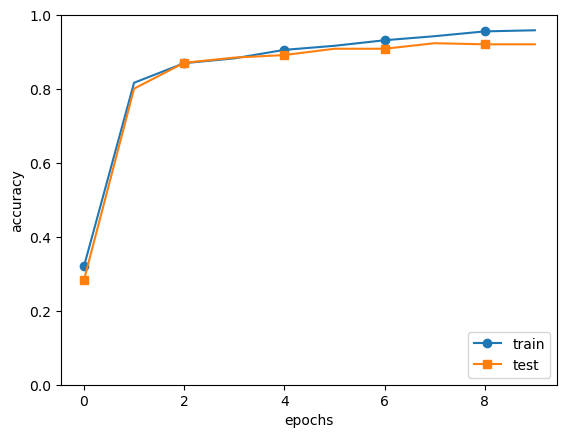

In [63]:
# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()